# Differentiation

In this tutorial, we will look at a number of ways to calculate the derivative of a function, and also look at how we might use these derivatives in an optimisation process using gradient descent.

## Differentiation by hand

Given a sufficiently simple function, it can be easy to compute its derivative by hand. For example in the code below, we compute the derivative of `x**3`:

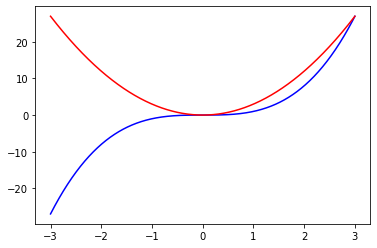

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-3, 3, num=1000)
x_cubed = x**3

# The derivative of x**3 is 3*x**2
x_deriv = 3 * (x ** 2)

plt.plot(x, x_cubed, "b")
plt.plot(x, x_deriv, "r")

If you have a more complex function, but the function is still known, it may also be possible to get the computer to compute the derivative for you using a symbolic differentiation package such as [sympy](https://www.sympy.org/en/index.html).

Exact gradients of this kind, where you have a mathematical formula for the gradient function, are often called *analytic gradients*.

## Finite differences

Sometimes you may only have access to the output of a function, and not have a defined mathematical formula describing it. In this case differentiating as shown above is not possible. However it is still possible to estimate the derivative using [finite difference](https://en.wikipedia.org/wiki/Finite_difference) methods.

The most straightforward way to estimate the gradient of a function f(x) is to pick a small offset h, and then compute the forward difference f(x+h) - f(x) / h

We can do this manually using a for loop:

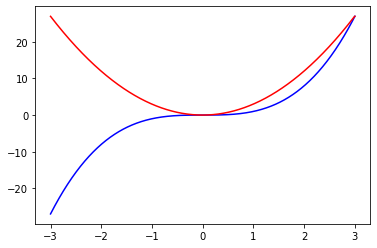

In [24]:
n_samples = 1000

x = np.linspace(-3, 3, num=n_samples)
x_cubed = x**3

h = (3 - (-3)) / n_samples # The step size

def finite_differences(values, stepsize):
    deriv = np.zeros_like(values)

    for i in range(len(x)-1):
        deriv[i] = (values[i+1] - values[i]) / stepsize

    # For the last element we have to use a backward difference:
    deriv[-1] = (values[-1] - values[-2]) / stepsize
    return deriv

x_deriv_est = finite_differences(x_cubed, h)

plt.plot(x, x_cubed, "b")
plt.plot(x, x_deriv_est, "r")

In this case this approximates the true gradient reasonably well:

False


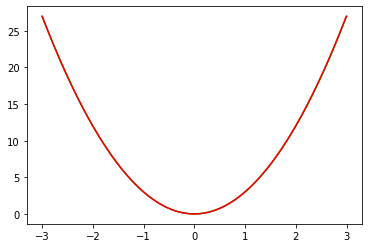

In [15]:
plt.plot(x, x_deriv, "g")
plt.plot(x, x_deriv_est, "r")

# But it isn't close enough for np.allclose():
print(np.allclose(x_deriv, x_deriv_est))

Numpy has a built in function `numpy.gradient()` that computes gradients. This also uses a finite differences method, but a more sophisticated second order implementation (see the [documentation](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html) for details).

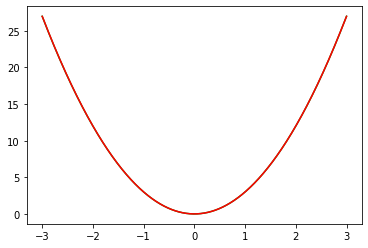

In [21]:
n_samples = 1000

x = np.linspace(-3, 3, num=n_samples)
x_cubed = x**3

h = (3 - (-3)) / n_samples # The step size

grad = np.gradient(x_cubed, h)

plt.plot(x, x_deriv, "g")
plt.plot(x, grad, "r")

It's important to remember that how well any finite differences methods will work depends heavily on the function and the step size h. If the function is too complex or the step size too large, the gradient may be very inaccurate.

Gradients derived from a method like finite differences are often referred to as *numerical* gradients.

## Gradient descent and optimisation

Now that we have explored some ways to calculate gradients, we will look at an application for them - gradient descent. This is a widely used technique to find the minimum of a function.

The general idea is to start from some point in the range of the function. We then follow an iterative process where at each step we move along the negative gradient of the function. Generally the step is multiplied by a constant called the learning rate:

x = x - learning_rate * dx

Eventually this should converge to the minimum of the function. However the learning rate and the initial point chosen to begin the process are both very important in obtaining good convergence.

Below is a simple 2D example, finding the minimum of x**2:

Final value: -0.0504791074251593


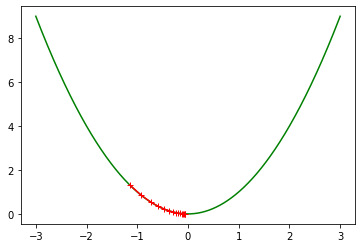

In [47]:
n_samples = 1000

x = np.linspace(-3, 3, num=n_samples)
x_squared = x**2

initial_x = (np.random.rand(1) * 6) - 3 # Select a random starting point in [-3, 3)
learning_rate = 0.1
n_steps = 15

step_vals = np.zeros([n_steps]) # Make an array to store the result of gradient descent at each step.
curr_x = initial_x
step_vals[0] = curr_x

for step in range(1, n_steps):
    curr_x = curr_x - learning_rate * (2 * curr_x) # Here we're using the gradient 2x.
    step_vals[step] = curr_x

step_vals_sq = step_vals**2

plt.plot(x, x_squared, "g")
plt.plot(step_vals, step_vals_sq, "r+-") # Plot all the steps in red, using +s

print("Final value:", step_vals[-1])

Try running the above example multiple times, and note that how close it is able to get to the real answer 0 depends on the starting location.

Also, try increasing the learning_rate value - note that it helps convergence up to a point, but above about 0.5 it can actually cause the approach not to converge.

Here is a 2D example, with a more complicated function. In this case the gradients are calculated using finite differences rather than analytically.

Final value: [ 1 -2]


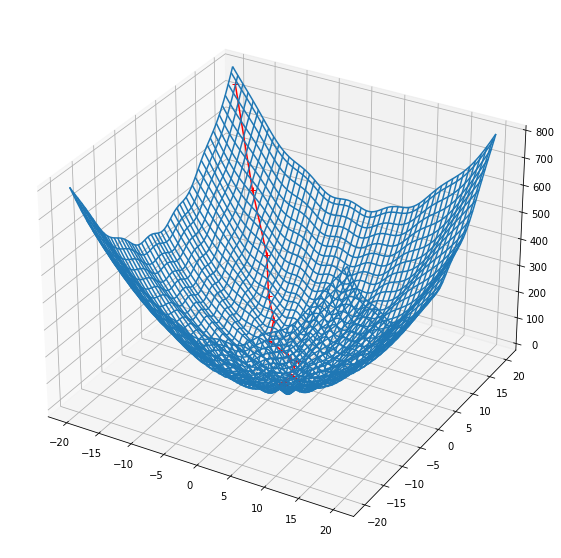

In [3]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

n_rows = 100

x = np.linspace(-20, 20, num=n_rows)
y = np.linspace(-20, 20, num=n_rows)
x, y = np.meshgrid(x, y)

# This makes the polar function r**2 + 10 * sin(20 * theta)
# This is a parabolic bowl with some oscillations from the sin function.
radius = np.sqrt(x*x + y*y)
angle = np.arctan2(y, x)
height = (radius**2) + 10*np.sin(angle*20)

stepsize = (20 - (-20)) / n_rows 

# Finding the gradients along each axis using finite differences.
x_grad_height = np.gradient(height, stepsize, axis=0)
y_grad_height = np.gradient(height, stepsize, axis=1)

# Parameters for the gradient descent - try changing these & see what happens!
initial_value = np.array([-19, 19])
learning_rate = 0.1
n_steps = 50

step_vals = np.zeros([n_steps, 2]) # Make an array to store the result of gradient descent at each step.
curr_val = initial_value
step_vals[0] = curr_val
step_heights = np.zeros([n_steps])

for step in range(1, n_steps):
    # Here we find the indices we need to look up in the gradient arrays to find the current gradient.
    # We're taking the nearest sample here for simplicity, but for more accuracy you could use an
    # interpolation method (for example `interpolate.interp2d` from 
    # [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html))
    x_idx = round(((curr_val[0] + 20) / 40) * n_rows)
    y_idx = round(((curr_val[1] + 20) / 40) * n_rows)

    # Now we use these indices to find the gradients in X and Y
    x_grad = x_grad_height[x_idx, y_idx]
    y_grad = y_grad_height[x_idx, y_idx]

    # Finally we can use these gradient values to take a step in the gradient descent.
    curr_val[0] -= learning_rate * x_grad
    curr_val[1] -= learning_rate * y_grad

    step_vals[step, :] = curr_val
    step_heights[step-1] = height[x_idx, y_idx]

# Print the final position ()
print("Final value:", curr_val)

ax.plot_wireframe(x, y, height)
ax.plot(step_vals[:,0], step_vals[:,1], step_heights, "r+-")

plt.show()

## Automatic Differentiation

Often in optimisation and machine learning tasks, we want to compute gradients for quite complex functions. A popular example at the moment are neural networks - these networks are large and complex, but are made up of many simple components. Each component may have a simple analytic gradient, but working out the gradient for the whole network is more challenging. In principle it could be done by hand, making use of the chain rule. In practice this is time-consuming and error-prone.

Fortunately, a variety of libraries are available which can compute derivatives of complicated functions automatically. This capability is often called automatic differentiation, or autograd for short.

Autograd is a standard feature of deep-learning libraries such as Pytorch. Below is a minimal example of using pytorch to automatically estimate a gradient.

If you're running these notebooks locally, for these examples you will need to install pytorch. I'd recommend following the official [install guide here](https://pytorch.org/get-started/locally/) to install it on your machine.

In [100]:
import torch

x = torch.tensor([1.0]) # Pytorch uses its own data structure called tensors - these are very similar to numpy arrays.

x.requires_grad = True # This tells pytorch that we want gradients to be calculated for x.

x_squared = x ** 2

x_squared.backward() # This works backward from x_squared, finding gradients at each step

print(x.grad) # Now we can find the gradient of x_squared with respect to x
# This should be 2, as we're evaluating it at x = 1.0


tensor([2.])


As mentioned above, calling `x_squared.backward()` works backward from the tensor `x_squared`, looking at all the operations and variables used to create it. It then determines the gradient looking at all of these.

In this case, there's only one variable `x` and we've only performed a single operation (squaring). However the strength of libraries like pytorch is that they can determine gradients even for complex combinations of operations and variables.

Like above, you only need to implement the function you want to differentiate (often called the *forward pass*). Calling `backward()` will automatically perform the gradient calculation (the *backward pass*) for you.

We can use this auto-differentiation feature to make implementing gradient descent much simpler. Let's try this with a more complicated function.

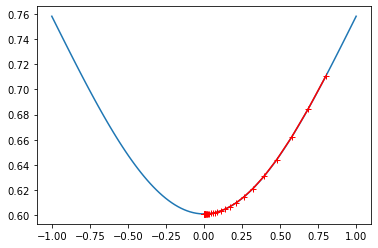

In [142]:
import torch, math

import matplotlib.pyplot as plt

x = torch.tensor([0.8], requires_grad=True) # You can also set requires_grad in the initialiser function here.

# This time we're minimising 1.0 - gaussian(x), where gaussian() is a gaussian function (the PDF of a standard
# normal distribution).
def gaussian(x, sigma=1.0, mu=0.0):
    scale = 1.0 / (sigma * math.sqrt(2.0 * math.pi))
    return scale * torch.exp(-0.5 * (x - mu) * (x - mu) / (sigma * sigma))

# Let's first plot the graph of the function we're minimising.
x_vals = torch.linspace(-1, 1)
y_vals = 1.0 - gaussian(x_vals)
plt.plot(x_vals, y_vals)

step_vals = [x.item()]

# The gradient descent loop has the same overall structure as before.
n_iters = 30
learning_rate = 0.5

for iter in range(n_iters):
    y = 1.0 - gaussian(x)
    y.backward() # As before, we call backward() to calculate the gradients we need.

    # We turn off gradient calculation when doing the update step.
    with torch.no_grad():
        x -= learning_rate * x.grad
    
    # It's really important that we zero the gradients here - if you don't they'll keep adding on
    # and the GD won't converge.
    x.grad.zero_()

    # Save the value of x so we can plot them later.
    step_vals.append(x.item())

# Plot the gradient descent steps.
step_vals = torch.tensor(step_vals)
step_y_vals = 1.0 - gaussian(step_vals)
plt.plot(step_vals, step_y_vals, "r+-")


In the above, we used pytorch's automatic differentiation to work out the gradient. However, we still implemented the gradient descent ourselves.

However, pytorch has a selection of built in optimisation functions, which we can use to simplify the task further. These include basic gradient descent like we used above, but also more sophisticated optimisers which make use of techniques like momentum to hopefully converge faster.

One popular optimiser commonly used in neural networks is Adam - let's try the above again, but use the built-in optimisation functionality in pytorch.

Note that the best optimiser to use heavily depends on the task - in this case, for this nice, well behaved function simple gradient descent converges faster than Adam. However Adam may work better than GD on more challenging functions.

Final value of x: 0.025038253515958786


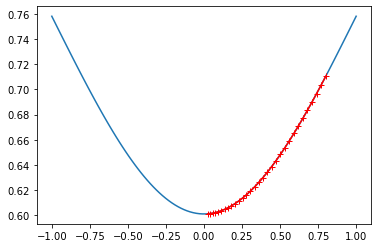

In [149]:
import torch, math
import matplotlib.pyplot as plt

x = torch.tensor([0.8], requires_grad=True) # You can also set requires_grad in the initialiser function here.

# This time we're minimising 1.0 - gaussian(x), where gaussian() is a gaussian function (the PDF of a standard
# normal distribution).
def gaussian(x, sigma=1.0, mu=0.0):
    scale = 1.0 / (sigma * math.sqrt(2.0 * math.pi))
    return scale * torch.exp(-0.5 * (x - mu) * (x - mu) / (sigma * sigma))

# Let's first plot the graph of the function we're minimising.
x_vals = torch.linspace(-1, 1)
y_vals = 1.0 - gaussian(x_vals)
plt.plot(x_vals, y_vals)

step_vals = [x.item()]

# The gradient descent loop has the same overall structure as before.
n_iters = 30
learning_rate = 0.03

# This time we create an optimzer object, and tell it which tensors we want to optimize
optimizer = torch.optim.Adam(params=[x], lr=learning_rate) 
# Try swapping this out for other optimisers like torch.optim.SGD and see how well they perform.

for iter in range(n_iters):
    optimizer.zero_grad() # This does the same thing as x.grad.zero_() above, zeroing the gradients.

    y = 1.0 - gaussian(x)
    y.backward() # As before, we call backward() to calculate the gradients we need.

    optimizer.step() # This time we call optimizer.step() to update x

    # Save the value of x so we can plot them later.
    step_vals.append(x.item())

print("Final value of x:", x.item())

# Plot the gradient descent steps.
step_vals = torch.tensor(step_vals)
step_y_vals = 1.0 - gaussian(step_vals)
plt.plot(step_vals, step_y_vals, "r+-")

### Note on Stochastic Gradient Descent

You might notice that the gradient descent implementation in pytorch is called `SGD`, which stands for *Stochastic* Gradient Descent. However it is the same algorithm as the normal gradient descent we have described above. You may be curious why the term stochastic is used.

Suppose we're performing an optimisation over a large number of data samples. This is common in the deep learning tasks that pytorch was designed to handle. There are two possible ways you could try to optimise over the dataset:

1. Input all the data to the function at once, find a single gradient for all of it. Then use this gradient to update the desired variables (e.g. the parameters of the neural network).
2. Input data items one at a time at random, and find gradients and update the variables each time.

Option 1 is almost always impossible, because the size of typical datasets would exceed the RAM available. Because of this option 2 is taken, but this is not true gradient descent over the dataset. It's an approximation to finding the true gradient, with a random element, and for this reason it's called *stochastic* gradient descent.

In practice normally a small group of data samples (a *batch*) is used at each step of SGD.